In [1]:
%matplotlib notebook
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import matplotlib.dates as dates

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, desc, extract

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
last12 = session.query(Measurement.date,Measurement.prcp).\
filter(Measurement.date.between('2016-08-23','2017-08-23')).\
order_by(Measurement.date).all()

# Calculate the date one year from the last date in data set
prev_year = dt.date.today() - dt.timedelta(days=365)
# Perform a query to retrieve the data and precipitation scores

# Save the query results as a Pandas DataFrame and set the index to the date column
date_df = pd.DataFrame(last12[:],columns=['Date','Precipitation'])

# Sort the dataframe by date
date_df.set_index('Date',inplace=False)
date_df.head()
# Use Pandas Plotting with Matplotlib to plot the data
dates=date_df["Date"]
dates.tolist()
plt.plot(date_df["Precipitation"])
# Rotate the xticks for the dates
plt.title('Precipitation Over 12months')
plt.xlabel('Date')
plt.ylabel("Precipitation (by inch)")

# fig.autofmt_xdate()
plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>

In [11]:
# Use Pandas to calcualte the summary statistics for the precipitation data
date_df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [12]:
# How many stations are available in this dataset?
stations=session.query(Station.station).count()
stations

9

In [13]:
# What are the most active stations?
# List the stations and the counts in descending order.
active_stations = session.query(Measurement.station,Measurement.tobs)
stations_df=pd.DataFrame(active_stations[:],columns=["Stations","TOBS"])
active_stations2=stations_df.groupby("Stations").count().sort_values('TOBS',ascending=False)
active_stations2

,TOBS
Stations,
USC00519281,2772
USC00519397,2724
USC00513117,2709
USC00519523,2669
USC00516128,2612
USC00514830,2202
USC00511918,1979
USC00517948,1372
USC00518838,511


In [14]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
temp=stations_df.loc[stations_df['Stations']==active_stations2.index[0]]
temp
results1=[temp["TOBS"].min(),temp["TOBS"].max(),temp["TOBS"].mean()]
results1

[54.0, 85.0, 71.66378066378067]

In [15]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
hightemp=active_stations2.index[0]
hightemp
all_temp = session.query(Measurement.station, Measurement.date, Measurement.tobs).\
    filter(Measurement.date.between('2016-08-23','2017-08-23')).\
    filter(Measurement.station==hightemp).\
    order_by(Measurement.date).all()
temp_df = pd.DataFrame(all_temp)
temp_df.hist(bins=12)
plt.title('Temperature Over 12months')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>

In [16]:
# Write a function called `calc_temps` that will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [17]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
tMAM=calc_temps('2016-08-23','2017-08-23')
tMAM

[(58.0, 74.59058295964125, 87.0)]

<IPython.core.display.Javascript object>


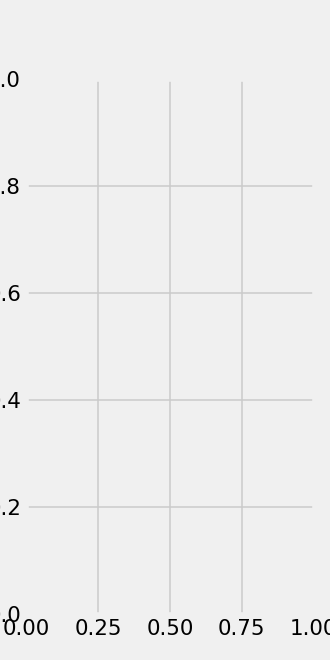

TypeError: list indices must be integers or slices, not str

In [21]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
plt.figure(figsize=(3,6))
plt.bar(data=tMAM,color="blue")
plt.title('Trip Avg Temp')
plt.tight_layout()
plt.show()

In [ ]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
session.query(Measurement.station, Station.name, Station.latitude, Station.longitude, Measurement.prcp).\
    filter(Measurement.date.between('2016-08-23','2017-08-23')).\
    group_by(Measurement.station).\
    join(Station, Measurement.station==Station.station).\
    order_by(Measurement.prcp.desc()).all()


## Optional Challenge Assignment

In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
